In [2]:
# Authors: Bellet, Gramfort, Salmon

from time import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [3]:
###############################################################################
# Requires file ijcnn1.dat to be present in the directory

dataset_path = 'ijcnn1.dat'
ijcnn1 = load_svmlight_file(dataset_path)
X = ijcnn1[0].todense()
y = ijcnn1[1]

###############################################################################
# Extract features

X_train, X_test, y_train, y_test = train_test_split(X[:60000, :], y[:60000],
                     train_size=20000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
###############################################################################
# SVM classification (Question 1)

from sklearn.svm import SVC, LinearSVC

print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
clf = SVC()
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t1 = time()
accuracy_kernel = clf.score(X_test, y_test)
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t1
print("classification accuracy: %0.3f" % accuracy_kernel)

# TODO with LinearSVC

print()
print("Fitting LinearSVC on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
clf = LinearSVC(dual=False)
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with LinearSVC on %d samples..." % X_test.shape[0])
t1 = time()
accuracy_kernel = clf.score(X_test, y_test)
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t1
print("classification accuracy: %0.3f" % accuracy_kernel)

Fitting SVC rbf on 20000 samples...
done in 3.269s
Predicting with SVC rbf on 40000 samples...
done in 4.235s
classification accuracy: 0.980

Fitting LinearSVC on 20000 samples...
done in 0.099s
Predicting with LinearSVC on 40000 samples...
done in 0.005s
classification accuracy: 0.917


In [20]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd
def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        u, v, vt = svds(gram_mat, k)
        gram_mat_k = np.dot(np.dot(u, np.diag(v)), np.transpose(u))
    else:
        u, v, vt = svd(gram_mat)
        gram_mat_k = np.dot(np.dot(u[:,:k], np.diag(v[:k])), np.transpose(u[:,:k]))

    return gram_mat_k


In [26]:

###############################################################################
# Gram approximation

p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error_fast = np.zeros(n_ranks)
rel_error_slow = np.zeros(n_ranks)

# TODO : Question 2 Implement rank_trunc function in source file



# TODO : Question 3 Evaluate accuracy with Frobenius norm as a function
# of the rank for both svd solvers

# Use linalg.norm(A, 'fro') to compute Frobenius norm of A

for k, rank in enumerate(ranks):
    t1 = time()
    rel_error_fast[k] = linalg.norm(rank_trunc(gram_signal, rank, fast=True) - gram_signal,'fro') / linalg.norm(gram_signal, 'fro')
    timing_fast[k] = time() - t1
    
    t1 = time()
    rel_error_slow[k] = linalg.norm(rank_trunc(gram_signal, rank, fast=False) - gram_signal,'fro') / linalg.norm(gram_signal, 'fro')
    timing_slow[k] = time() - t1
    
    

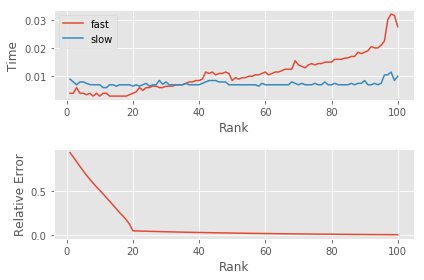

In [31]:
###############################################################################
# Display

fig, axes = plt.subplots(ncols=1, nrows=2)
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label="fast")
ax1.plot(ranks, timing_slow, '-', label="slow")

ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')
ax1.legend()
ax2.plot(ranks, rel_error_slow, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')
plt.tight_layout()
plt.show()


In [52]:
import math
def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    X_new_train = np.zeros((X_train.shape[0], c))
    X_new_test = np.zeros((X_test.shape[0], c))
    
    rng = np.random.RandomState(seed)
    # TODO Question 4
    W = 2 * gamma * rng.randn(X_train.shape[1], c) 
    b = rng.uniform(low=0, high=2*np.pi, size=c)
    
    for i in range(X_train.shape[0]):
        X_new_train[i,:] = np.sqrt(2. / c)*np.cos(np.dot(X_train[i,:], W) + b)
        
    for i in range(X_test.shape[0]):
        X_new_test[i,:] = np.sqrt(2. / c)*np.cos(np.dot(X_test[i,:], W) + b)
    return X_new_train, X_new_test

In [53]:
###############################################################################
# Random Kernel Features:

n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features

# TODO : Question 4 Implement random features in source file

Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)

In [56]:
print(Z_train.shape)
print(X_train.shape)

(20000, 300)
(20000, 22)


### Question 5

In [54]:
# TODO : Question 5 Estimate training, testing time and accuracy

print("Fitting LinearSVC on %d samples..." % Z_train.shape[0])
t0 = time()
# TODO
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with LinearSVC on %d samples..." % X_test.shape[0])
t1 = time()
accuracy_kernel = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t1
print("classification accuracy: %0.3f" % accuracy_kernel)

Fitting LinearSVC on 20000 samples...
done in 1.163s
Predicting with LinearSVC on 40000 samples...
done in 0.025s
classification accuracy: 0.934


In [72]:
###############################################################################
# SVM Nystrom:
from sklearn.metrics.pairwise import rbf_kernel
def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    I = rng.randint(X_train.shape[0], size=c)
    Gij = rbf_kernel(X_train[I,:], X_train[I,:], gamma=gamma)
    
    u, v, vt = svd(Gij)
    
    Mk = np.dot(u[:,:k], np.diag(1/np.sqrt(v[:k])))
    
    T_train = rbf_kernel(X_train, X_train[I,:], gamma=gamma)
    T_test = rbf_kernel(X_test, X_test[I,:], gamma=gamma)
    
    X_new_train = np.dot(T_train, Mk)
    X_new_test = np.dot(T_test, Mk)
    
    # TODO Question 6
    return X_new_train, X_new_test


# TODO : Question 6 Implement Nystrom in source file

Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=200, seed=2)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)

Fitting SVC linear on 20000 samples...
done in 0.849s
Predicting with SVC linear on 40000 samples...
done in 0.020s
classification accuracy: 0.671


In [ ]:
####################################################################
# Results / comparisons:

ranks = list(range(20, 750, 50))
n_ranks = len(ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    # t0 = time()
    # TODO Question 8

    # accuracy_rkf[i] = ...
    # timing_rkf[i] = time() - t0
    pass

In [ ]:
###############################################################################
# Display bis

fig, axes = plt.subplots(ncols=1, nrows=2)
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()